In [38]:
# Cargo las librerias que voy a utilizar.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from fuzzywuzzy import fuzz
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

En mi Modelo de ML decidi realizar dos pruebas ambos partiendo del mismo csv pero se le realizan acciones distintas a ambos.

In [39]:
# Leo el CSV que voy a utilizar para realizar el modelo junto a las columnas que voy a utilizar.
df = pd.read_csv("plataformas.csv", usecols=['id', 'type', 'title', 'listed_in', 'score'])

In [40]:
df['title'] = df['title'].str.strip()

In [78]:
df[df['title'] == 'tarzan'] 

,index,id,type,title,listed_in,score
7601,9423,as9424,movie,tarzan,"action, animation, drama",3.5
8107,10160,ds493,movie,tarzan,"action-adventure, animation, coming of age",3.5
15944,22342,ns8152,movie,tarzan,children & family movies,3.6


In [42]:
# Realizo unos vistazos rapidos.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22998 entries, 0 to 22997
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         22998 non-null  object 
 1   type       22998 non-null  object 
 2   title      22998 non-null  object 
 3   listed_in  22998 non-null  object 
 4   score      22998 non-null  float64
dtypes: float64(1), object(4)
memory usage: 898.5+ KB


In [43]:
df.head(2)

,id,type,title,listed_in,score
0,as1,movie,the grand seduction,"comedy, drama",3.5
1,as2,movie,take care good night,"drama, international",3.5


In [44]:
# Para que el modelo sea mas liviano decido filtrar las columnas solo por movie y crear 2 dataframe.
df = df[df['type']== 'movie'].reset_index()
df_corr = df[df['type']== 'movie']

In [45]:
df_corr

,index,id,type,title,listed_in,score
0,0,as1,movie,the grand seduction,"comedy, drama",3.5
1,1,as2,movie,take care good night,"drama, international",3.5
2,2,as3,movie,secrets of deception,"action, drama, suspense",3.5
3,3,as4,movie,pink: staying true,documentary,3.5
4,4,as5,movie,monster maker,"drama, fantasy",3.5
...,...,...,...,...,...,...
16476,22992,ns8802,movie,zinzana,"dramas, international movies, thrillers",3.6
16477,22993,ns8803,movie,zodiac,"cult movies, dramas, thrillers",3.4
16478,22995,ns8805,movie,zombieland,"comedies, horror movies",3.4
16479,22996,ns8806,movie,zoom,"children & family movies, comedies",3.6


In [46]:
from IPython.display import display
valores_unicos = df['listed_in'].values
display(valores_unicos)


array(['comedy, drama', 'drama, international', 'action, drama, suspense',
       ..., 'comedies, horror movies',
       'children & family movies, comedies',
       'dramas, international movies, music & musicals'], dtype=object)

In [47]:
with open('valores_unicos.txt', 'w') as f:
    for valor in valores_unicos:
        f.write(str(valor) + '\n')


In [48]:
df.isnull().sum()

index        0
id           0
type         0
title        0
listed_in    0
score        0
dtype: int64

In [49]:
df_corr.isnull().sum()

index        0
id           0
type         0
title        0
listed_in    0
score        0
dtype: int64

En este punto deccidi que uno de los df iba a tener que modificar su columna listed_in. Esto devido a que las multiples pruebas en el deploy fallaban.
Al llevar las categorias o columna listed_in a solo un par de categorias el modelo presenta mucho menos carga de matrices. 
Para realizar esto verifique el ccontenido de la columna listed_in y lo distribui en las distintas categorias. Algunas se repiten ya que eso lo considere yo.

In [50]:
def separar_y_contar_caracteristicas(df, columna):
    caracteristicas = {}
    # Se itera sobre cada registro en la columna seleccionada del dataframe
    for registro in df[columna]:
        # Se separan las características del registro utilizando el separador ", "
        lista_caracteristicas = registro.split(', ')
        # Se itera sobre cada característica en la lista de características del registro
        for caracteristica in lista_caracteristicas:
        # Se actualiza el diccionario con la característica y su frecuencia
            if caracteristica not in caracteristicas:
                caracteristicas[caracteristica] = 1
            else:
                caracteristicas[caracteristica] += 1
    # Se retorna el diccionario con las características y su frecuencia
    return caracteristicas

In [51]:
dicci = separar_y_contar_caracteristicas(df_corr, 'listed_in')

In [52]:
# Define una función que agrupa las características similares de una lista de características dadas.
def agrupar_caracteristicas(caracteristicas):
    grupos = [] # crea una lista vacía para guardar los grupos
    
    # Itera por cada una de las características dadas
    for caracteristica in caracteristicas:
        pertenece_a_grupo_existente = False # Establece un valor inicial para la variable pertenece_a_grupo_existente
        
        # Itera por cada uno de los grupos existentes para verificar si la característica pertenece a alguno de ellos
        for grupo in grupos:
            # Compara la similitud entre la característica y el primer elemento del grupo usando la función token_set_ratio de la biblioteca FuzzyWuzzy
            similitud = fuzz.token_set_ratio(caracteristica, grupo[0])
            # Si la similitud es mayor al 30%, consideramos que pertenece al mismo grupo
            if similitud > 30:  
                # Añade la característica al grupo existente
                grupo.append(caracteristica)
                pertenece_a_grupo_existente = True # Cambia el valor de la variable pertenece_a_grupo_existente a True
                break # Sal del bucle for si ya se ha encontrado un grupo existente para la característica
        
        # Si la característica no pertenece a ningún grupo existente, crea un nuevo grupo con la característica como primer elemento
        if not pertenece_a_grupo_existente:
            grupos.append([caracteristica])
    
    # Crea un diccionario para guardar los grupos de características similares
    caracteristicas_agrupadas = {}
    
    # Itera por cada uno de los grupos
    for i, grupo in enumerate(grupos):
        nombre_grupo = f'Grupo {i+1}' # Crea un nombre para el grupo
        caracteristicas_agrupadas[nombre_grupo] = grupo # Agrega el grupo al diccionario con el nombre correspondiente
    
    return caracteristicas_agrupadas # Devuelve el diccionario con los grupos de características similares

In [53]:
grupos = agrupar_caracteristicas(dicci)

In [54]:
print(grupos)

{'Grupo 1': ['comedy', 'action', 'documentary', 'anime', 'romance', 'unscripted', 'family', 'movies', 'coming of age', 'concert film', 'crime', 'variety', 'parody', 'romantic comedy', 'buddy', 'medical', 'reality', 'mystery', 'documentaries', 'black stories', 'history', 'cooking & food', 'sitcom', 'comedies', 'horror movies', 'cult movies', 'stand-up comedy'], 'Grupo 2': ['drama', 'international', 'fantasy', 'entertainment', 'animation', 'musical', 'biographical', 'animals & nature', 'dance', 'survival', 'disaster', 'dramas', 'anime features'], 'Grupo 3': ['suspense', 'special interest', 'science fiction', 'adventure', 'sports', 'western', 'arthouse', 'music', 'lifestyle', 'superhero', 'spy/espionage', 'news', 'teen', 'classics', 'science & technology', 'independent movies', 'classic movies', 'sports movies'], 'Grupo 4': ['kids', 'fitness', 'thrillers'], 'Grupo 5': ['horror', 'historical', 'thriller', 'anthology'], 'Grupo 6': ['arts', 'latino', 'cartoons', 'health & wellness', 'sci-fi 

In [55]:
#Cree el diccionario qeu voy a utilizar
categorias = {'comedy': ['comedy', 'action', 'romance', 'family', 'coming of age', 'parody', 'romantic comedy', 'buddy', 'medical', 
              'reality', 'mystery', 'black stories', 'sitcom', 'comedies','stand-up comedy','stand up'], 
  
              'drama': ['drama', 'romantic movies', 'fantasy', 'survival', 'disaster', 'dramas','coming of age', 'crime','teen','romance','family'], 
              
              'science fiction': ['science fiction', 'adventure', 'western', 'superhero', 'spy/espionage', 'sci-fi & fantasy', 'action-adventure', 'action & adventure', 'science fiction'], 
              
              'animation': ['kids', 'cartoons','cartoon', 'animation','anime','adult animation','anime features'], 
              
              'thriller': ['horror', 'historical','suspense', 'thriller', 'anthology', 'thrillers','mystery','horror movies','cult movies'], 
              
              'documentaries': ['and culture','history','documentary', 'documentaries','biographical','animals & nature', 'military and war', 'young adult audience', 
                                'talk show and variety', 'special interest','special interest', 'lifestyle & culture', 'lifestyle', 'arthouse',
                                'sports movies', 'sports', 'fitness','cooking & food','arts', 'latino', 'health & wellness','science & technology'], 
              
              'action': ['suspense', 'science fiction', 'adventure', 'western', 'superhero', 'spy/espionage', 'sci-fi & fantasy', 'action-adventure', 'action & adventure', 'science fiction'], 
              
              'others': ['children & family movies', 'international movies','lgbtq', 'lgbtq+', 'lgbtq movies','entertainment','unscripted','movies','international',
                         'news','classics','independent movies', 'classic movies'], 
              
              'music': ['music & musicals', 'music', 'faith & spirituality','music videos and concerts', 'faith and spirituality','dance','musical','concert film','variety']}

In [56]:
# Agregar una nueva columna al DataFrame df_corr con las categorías que corresponden a cada registro
df_corr['categorias'] = df['listed_in'].apply(lambda x: ','.join([key for key, value in categorias.items() if any(val in x for val in value)]))
# El método apply se usa para aplicar la función lambda a cada elemento de la columna 'listed_in' del DataFrame df
# La función lambda se encarga de buscar las categorías que corresponden a cada registro a partir de la columna 'listed_in'
# La función lambda toma como entrada cada registro de la columna 'listed_in' y realiza lo siguiente:
    # Crea una lista con las claves del diccionario categorias que tienen al menos un valor que coincide con la lista de características del registro
    # Esta lista se crea usando una comprensión de listas y la función any(), que verifica si al menos un elemento de la lista de valores del diccionario está presente en la lista de características del registro
    # Luego, la lista de claves se une usando una coma y se devuelve como la categoría del registro
# El resultado se asigna a la nueva columna 'categorias' del DataFrame df_corr


In [57]:
df_corr.head()

,index,id,type,title,listed_in,score,categorias
0,0,as1,movie,the grand seduction,"comedy, drama",3.5,"comedy,drama"
1,1,as2,movie,take care good night,"drama, international",3.5,"drama,others"
2,2,as3,movie,secrets of deception,"action, drama, suspense",3.5,"comedy,drama,thriller,action"
3,3,as4,movie,pink: staying true,documentary,3.5,documentaries
4,4,as5,movie,monster maker,"drama, fantasy",3.5,drama


In [58]:
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16481 entries, 0 to 16480
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       16481 non-null  int64  
 1   id          16481 non-null  object 
 2   type        16481 non-null  object 
 3   title       16481 non-null  object 
 4   listed_in   16481 non-null  object 
 5   score       16481 non-null  float64
 6   categorias  16481 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 1.0+ MB


In [59]:
#Dropeo las columnas que no voy a usar.
df_corr.drop(columns=['index', 'id','type','listed_in'],inplace= True )

En este punto en un momento intente otro modelo donde generaba variables dummies pero el mismo se volvia insostenible era demasiado pesado. Decidi descartarlo pero les proveo la creacion de las columnas por si alguno le interesa realizar pruebas.

creo las columnas dummies
df_corr[['comedy', 'drama', 'action', 'adventure', 'thriller', 'sports', 'documentaries', 'science fiction', 'anime', 'animation', 'fantasy', 'others']] = 0

itero sobre las columnas dummies y verifica si la columna "categorias" contiene la subcadena correspondiente
for col in df_corr[['comedy', 'drama', 'action', 'adventure', 'thriller', 'sports', 'documentaries', 'science fiction', 'anime', 'animation', 'fantasy', 'others']]:
    df_corr[col] = df_corr['categorias'].str.contains(col, case=False).astype(int)


In [60]:
# Verifico como quedo el DF.
df_corr

,title,score,categorias
0,the grand seduction,3.5,"comedy,drama"
1,take care good night,3.5,"drama,others"
2,secrets of deception,3.5,"comedy,drama,thriller,action"
3,pink: staying true,3.5,documentaries
4,monster maker,3.5,drama
...,...,...,...
16476,zinzana,3.6,"drama,thriller,others"
16477,zodiac,3.4,"drama,thriller,others"
16478,zombieland,3.4,"comedy,thriller,others"
16479,zoom,3.6,"comedy,drama,others"


<b><font size="16"><font face="Arial"><font color="red">EDA</font><b>

In [61]:
df_corr.head()

,title,score,categorias
0,the grand seduction,3.5,"comedy,drama"
1,take care good night,3.5,"drama,others"
2,secrets of deception,3.5,"comedy,drama,thriller,action"
3,pink: staying true,3.5,documentaries
4,monster maker,3.5,drama


In [62]:
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16481 entries, 0 to 16480
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       16481 non-null  object 
 1   score       16481 non-null  float64
 2   categorias  16481 non-null  object 
dtypes: float64(1), object(2)
memory usage: 515.0+ KB


<b>Este EDA lo realizo en base al dataset que uso para ML<b>

Lo que busco revisar con estos graficos es las caracteristicas unicas de cada pelicula.


Por ejemplo el primer grafico compare cual era la categoria que mas se repetia de manera individual.


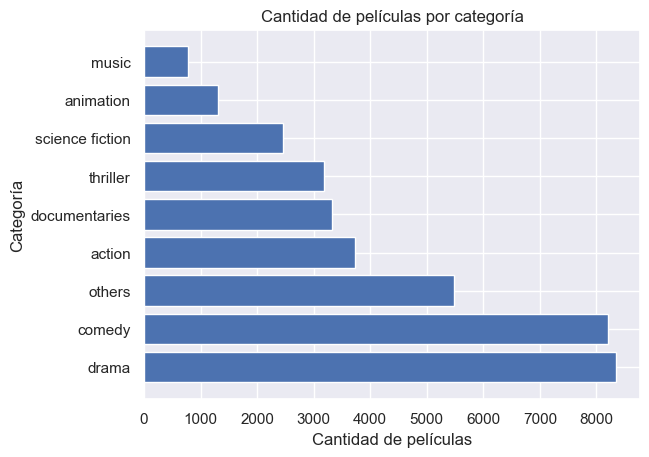

In [63]:
df1 = df_corr
df1['categorias_list'] = df1['categorias'].str.split(',')
df_exploded = df1.explode('categorias_list')

categorias_count = df_exploded['categorias_list'].value_counts()
plt.barh(categorias_count.index, categorias_count.values)
plt.title("Cantidad de películas por categoría")
plt.xlabel("Cantidad de películas")
plt.ylabel("Categoría")
plt.show()


El segundo utilice un grafico circular para verlo de manera porcentual.

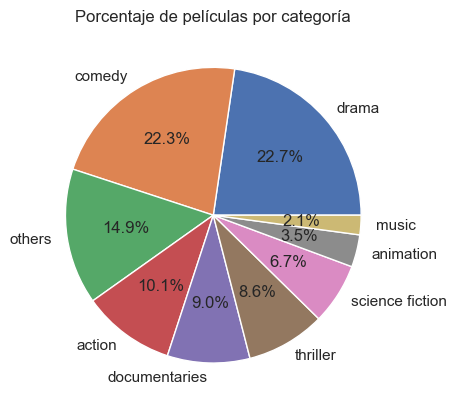

In [64]:
plt.pie(categorias_count.values, labels=categorias_count.index, autopct='%1.1f%%')
plt.title("Porcentaje de películas por categoría")
plt.show()

<b><font size="16"><font face="Arial"><font color="Blue">Modelo de Machine Learning</font><b>

<b>Similitud de Coseno<b>

A partir de aca realizo distintas pruebas para el modelo. 
Tome un modelo de recomendaccion por relacion de cosenos item-item. 
Donde ingresando un parametro decide buscar los mas parecidos.
Por ejemplo si le indico que busque palabras o oraciones que contengan la palabra "queso" el mismo bsucaria la que mas se acerca a lo buscado.
En este caso lo realizaremos por el titulo de la pelicula.

Aca simplemente realice un vistaso de como funciona el TfidfVectorizer.

In [65]:
# creo una instancia de TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')

# creo la matriz de frecuencia de términos
tfidf_matrix = tfidf.fit_transform(df_corr['categorias'])

# calculo la similitud de coseno
cosine_sim = cosine_similarity(tfidf_matrix)

# obtengo los índices de las películas más similares
similar_movies = list(enumerate(cosine_sim[10]))

# ordeno las películas por similitud
sorted_movies = sorted(similar_movies, key=lambda x: x[1], reverse=True)

# obtengo los índices de las 5 películas más similares
top_similar = [i[0] for i in sorted_movies[1:6]]

# imprimo las 5 películas más similares
print(df['title'].iloc[top_similar])

583                   stick man
623                 solar flare
1417                 hope ranch
1624    fairytale: a true story
1634                  explorers
Name: title, dtype: object


A partir de lo anterior empiezo a probar distintas funciones.

Esta es mi primer prueba una funcion simple pero pesada. Tambien le faltaba arreglar detalles al codigo.

In [66]:
def get_recommendations(titulo_pelicula: str):
    
    # Creo el vectorizador TF-IDF
    vectorizer = TfidfVectorizer()

    # Aplico el vectorizador a la columna 'listed_in' para obtener la matriz de características
    tfidf_matrix = vectorizer.fit_transform(df['listed_in'])

    # Calculo la matriz de similitud de coseno
    cosine_sim = cosine_similarity(tfidf_matrix)

    # obtengo el índice de la película que coincide con el título proporcionado
    idx = df.index[df['title'] == titulo_pelicula.lower()].tolist()[0]

    # obtengo las puntuaciones de similitud de coseno de la película con todas las demás películas
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Ordeno las películas según las puntuaciones de similitud
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # obtengo las cinco películas más similares, excluyendo la película de entrada
    sim_scores = [i for i in sim_scores if df.index[i[0]] != idx]
    sim_scores = sim_scores[:5]

    # obtengo los títulos de las cinco películas más similares
    recomendaciones = df.iloc[[i[0] for i in sim_scores]]['title'].tolist()

    return {'recomendacion': recomendaciones}


In [67]:
get_recommendations('into the forest')


{'recomendacion': ['the lovely bones',
  "pan's labyrinth",
  'cosmos laundromat: first cycle',
  'rainbow jelly',
  'mirage']}

In [68]:
get_recommendations('the grand seduction')

{'recomendacion': ["summer '03",
  'you, me and him',
  'walter',
  'waiting on mary',
  'the romantics']}

In [69]:
get_recommendations('tarzan')

{'recomendacion': ['on happiness road',
  'metal skin panic madox-1',
  'nuttiest nutcracker',
  'iwish',
  'chance']}

In [70]:
df_corr.to_csv('ML.csv', index=False, encoding="utf-8")

In [71]:
df_corr.isnull().sum()

title              0
score              0
categorias         0
categorias_list    0
dtype: int64

In [72]:
# Creo el vectorizador TF-IDF
vectorizer = TfidfVectorizer()
# Aplico el vectorizador a la columna 'listed_in' para obtener la matriz de características
tfidf_matrix = vectorizer.fit_transform(df_corr['categorias'])
# Calculo la matriz de similitud de coseno
cosine_sim = cosine_similarity(tfidf_matrix)

In [81]:
def get_recommendationB(title: str):    
    
    #Me aseguro que si escriben en mayuscula llevarlo a minuscula.
    title = title.lower()
    
    # Creo el vectorizador TF-IDF
    tfidf = TfidfVectorizer(stop_words='english')
    
    # Aplico el vectorizador a la columna para obtener la matriz de características.
    tfidf_matrix = tfidf.fit_transform(df_corr['categorias'])
    
    # Obtengo el índice de la película que coincide con el título proporcionado
    idx = df_corr.index[df_corr['title'] == title.lower()].tolist()[0]
    
    # Calculo la matriz de similitud de coseno
    cosine_sim = cosine_similarity(tfidf_matrix[idx], tfidf_matrix)
    
    # Obtengo las puntuaciones de similitud de coseno de la película con todas las demás películas
    sim_scores = list(enumerate(cosine_sim[0]))
    
    # Ordeno las películas según las puntuaciones de similitud
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Obtengo las películas similares con la mejor puntuación de score
    sim_scores = [i for i in sim_scores if i[0] != idx]
    sim_scores = sorted(sim_scores, key=lambda x: df_corr['score'].iloc[x[0]], reverse=True)[:5]
    
    # Obtengo los títulos de las películas seleccionadas
    respuesta = df_corr.iloc[[i[0] for i in sim_scores]]['title'].tolist()
    
    
    return {'recomendacion': respuesta}

In [82]:
get_recommendationB('into the forest')

{'recomendacion': ['rolling home',
  'the westerner',
  'disney adventures in babysitting',
  'the journey of natty gann',
  'the man who killed hitler and then the bigfoot']}

In [83]:
get_recommendationB('the grand seduction')

{'recomendacion': ['15 minutes of war',
  'do you wanna dance?',
  'poor liza',
  "sara's",
  'server sundaram']}

In [84]:
get_recommendationB('tarzan')

{'recomendacion': ['lend a paw',
  'spirit rider',
  'joseph: king of dreams',
  'welcome to the space show (english dub)',
  'go buster - baby bus cartoons']}